# Macro-Induced Lightning Constraints

In [1]:
"""
    TITLE   : Macro-Induced Lightning Constraints
    AUTHOR  : Jagjit Sidhu, Nathaniel Starkman
    PROJECT : https://github.com/nstarman/macro_lightning
""";

__author__ = ['Jagjit Sidhu', "Nathaniel Starkman"]

<span style='font-size:30px;font-weight:650'>
    About
</span>

This notebook contains the calculations for how well macro-induced lightnint on Earth and Jupiter can constrain macro models.


<br><br>

- - - 


## Prepare

### Imports

In [2]:
# BUILT-IN

import sys
from itertools import product as iterprod

# THIRD PARTY

from astropy import units as u
from astropy.table import QTable
import matplotlib.pyplot as plt
import numpy as np
import utilipy
from tqdm import tqdm

# PROJECT SPECIFIC

from macro_lightning import plot, physics as ph
from macro_lightning import parameters
from macro_lightning.physics import f_BM_bin
from macro_lightning.utils import as_quantity, qsquare, qnorm, qarange


set autoreload to 1


### Parameters

In [3]:
load_saved = True

In [4]:
PI = np.pi
KMS = u.km / u.s

vcirc = 220.0 * KMS
vvir = 250 * KMS  # virial velocity
vesc = 550 * KMS  # Galactic escape velocity

v_start = -500 * KMS
v_step = 25 * KMS  # bin size

vels = qarange(v_start, vesc + v_step, v_step, unit=KMS)[::-1]

# mass
m_unit = u.g

# cross-section
sigma_unit = u.cm**2

<br><br>

- - - 


## Earth

We first perform the integral $$\Gamma(M_x, \sigma_x) = A_{det}\frac{\rho_{DM}}{M_x} \int_{v_{threshold}(\sigma_x;D)}^{v_{esc}}v_x f_{MBSS}(v_x) \rm{d}v_x $$

from https://arxiv.org/pdf/1908.00557.pdf

In [5]:
earth_sigmax = 6e-8 * u.cm ** 2  # Earth radius

vesc_sun_at_earth = 42.1 * u.km / u.s  # from https://ssd.jpl.nasa.gov/?planet_phys_par
vesc_earth = parameters.solar_system_vesc_params.get()["Earth"]
# vmin = ph.multibody_esc_v(vesc_sun_at_earth, vesc_earth)
vmin = qnorm(vesc_sun_at_earth, vesc_earth)
vmin


<Quantity 43.56175042 km / s>

In [6]:
try:
    if load_saved:
        macro = QTable.read("macro_msig_earth.asdf", format="asdf")
    else:
        raise Exception("load_saved = False")
except Exception as e:
    print("Can't load, ", e)

    Mhold, Shold, *_ = ph.calculate_Mx_and_Sx(
        vels,
        vvir=vvir,
        vesc=vesc,
        vcirc=vcirc,
        vmin=vmin,
        Arho = 3 * u.g * u.s / u.m,  # A_{det}*\rho_{DM}
        # kwargs
        sigmax=earth_sigmax,
        m_unit=m_unit,
        sig_unit=sigma_unit
    )

    macro = QTable([Mhold, Shold], names=["mass", "sigma"])
    macro.write("macro_msig_earth.asdf", format="asdf")

else:
    Mhold = macro["mass"]
    Shold = macro["sigma"]


  3%|▎         | 2379/79507 [00:00<00:03, 23782.37it/s]

Can't load,  


100%|██████████| 79507/79507 [00:11<00:00, 6920.86it/s] 


Plot Constraints

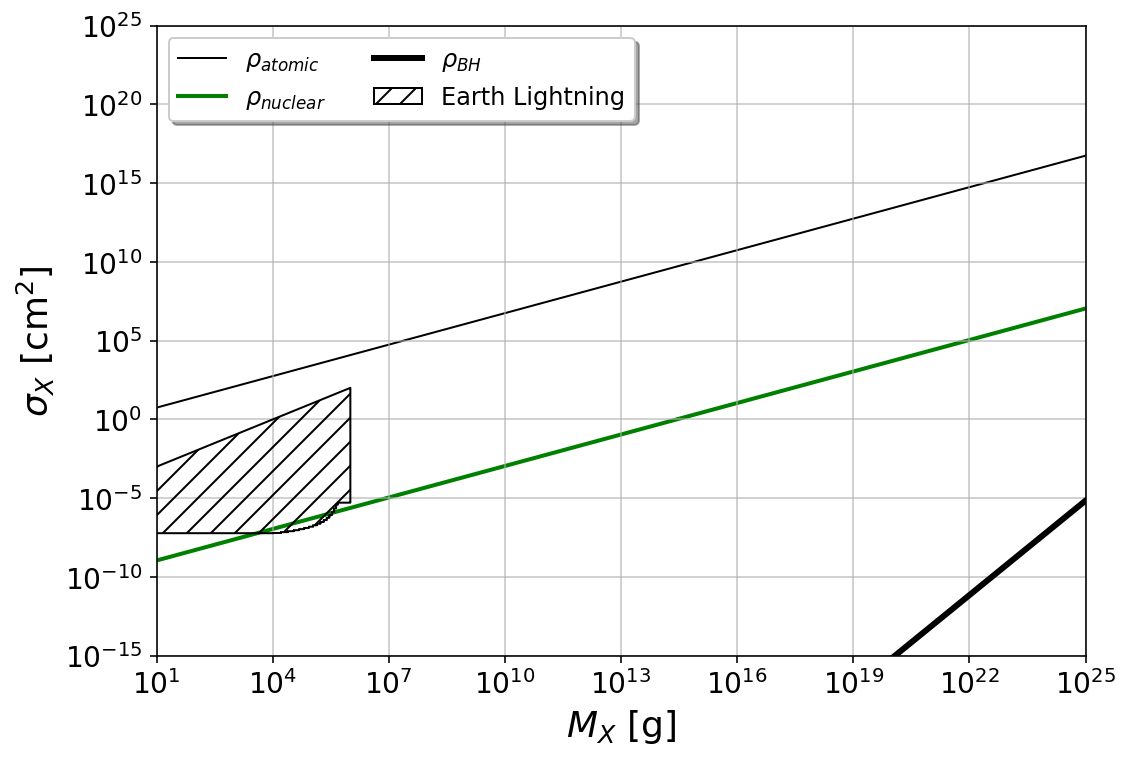

In [7]:
upperlightning = Mhold * 1e-4 * u.cm**2 / u.g

with plot.constraints_plot(np.logspace(1, 25), sigmin=1e-15):

    plt.fill_between(
        Mhold, Shold, upperlightning,
        where=None, 
        facecolor='none',
        edgecolor='black',
        hatch="//",
        alpha=1.0,
        zorder=8,
        label="Earth Lightning"
    )

plt.show();

## Jupiter

needs to be redone

In [8]:
jupitermasslightning = Mhold[:] * 2e3
uppersigmalightningjupiter = jupitermasslightning[:] * 1e-4


In [9]:
# vesc_sun_at_jupiter = 18.5 * u.km / u.s  # from https://ssd.jpl.nasa.gov/?planet_phys_par
# vesc_jupiter= parameters.solar_system_vesc_params.get()["Jupiter"]
# vmin = qnorm(vesc_sun_at_earth, vesc_jupiter)
# vmin


In [10]:
# try:
#     if load_saved:
#         macro = QTable.read("macro_msig_jupiter.asdf", format="asdf")
#     else:
#         raise Exception
# except Exception as e:
#     print("Can't load, ", e)

#     MholdJ, SholdJ, *_ = ph.calculate_Mx_and_Sx(
#         vels,
#         vvir=vvir,
#         vesc=vesc,
#         vcirc=vcirc,
#         vmin=vmin,
#         Arho = 1e5 / 3 * (u.g * u.s / u.m),
#         # kwargs
#         sigmax=ref_sigmax,
#         sigma_factor = 1e-10 * u.cm**6
#         m_unit=m_unit,
#         sig_unit=sigma_unit
#     )

#     macro = QTable([Mhold, Shold], names=["mass", "sigma"])
#     macro.write("macro_msig_jupiter.asdf", format="asdf")

# else:
#     MholdJ = macro["mass"]
#     SholdJ = macro["sigma"]



In [11]:
# vbar = 0.0 * u.km / u.s
# Vhold = 800.0 * u.km / u.s

# Mx_unit = u.g
# sigma_unit = u.cm**2

# Mhold=[]
# Shold=[]

# sigma_factor = 1e-10 * u.cm**6  # TODO why units?

# # calculate Mx
# for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
#     _v = qnorm(vx, vy, vz)
#     vrel = qnorm(vmin, vx, vy-vy_ref, vz)

#     if (vvir < vrel) & (_v <= vesc):  # TODO WHY?
#         maxwellian = f_BM_bin(_v, vbin=v_step, vvir=vvir)  # TODO understand normalization        

#         vbar = vbar + vrel * maxwellian  # cumulative

#         Mx = (1e5/3 * (u.g * u.s / u.m) * vbar).to_value(Mx_unit)  # TODO why?
#         Mhold.append(Mx)

#         Vhold = vrel    # problem? never reset Vhold
# # /for 

# # calculate sigmax
# for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
#     _v = qnorm(vx, vy, vz)
#     vrel = qnorm(vmin, vx, vy-vy_ref, vz)
#     if (vvir < vrel) & (_v <= vesc):  # TODO WHY?
#         if Vhold < vrel:
#             vrel = Vhold

#         sigmax = np.power(sigma_factor * (vvir / vrel)**7, 1./3)
#         # if sigmax < ref_sigmax:  # TODO why not this?
#         #     sigmax = ref_sigmax
#         Shold.append(sigmax.to_value(sigma_unit))

#         Vhold = vrel    # problem? never reset Vhold

# # /for

# Mhold = np.array(Mhold) * Mx_unit
# Shold = np.array(Shold) * sigma_unit


Plot Constraints

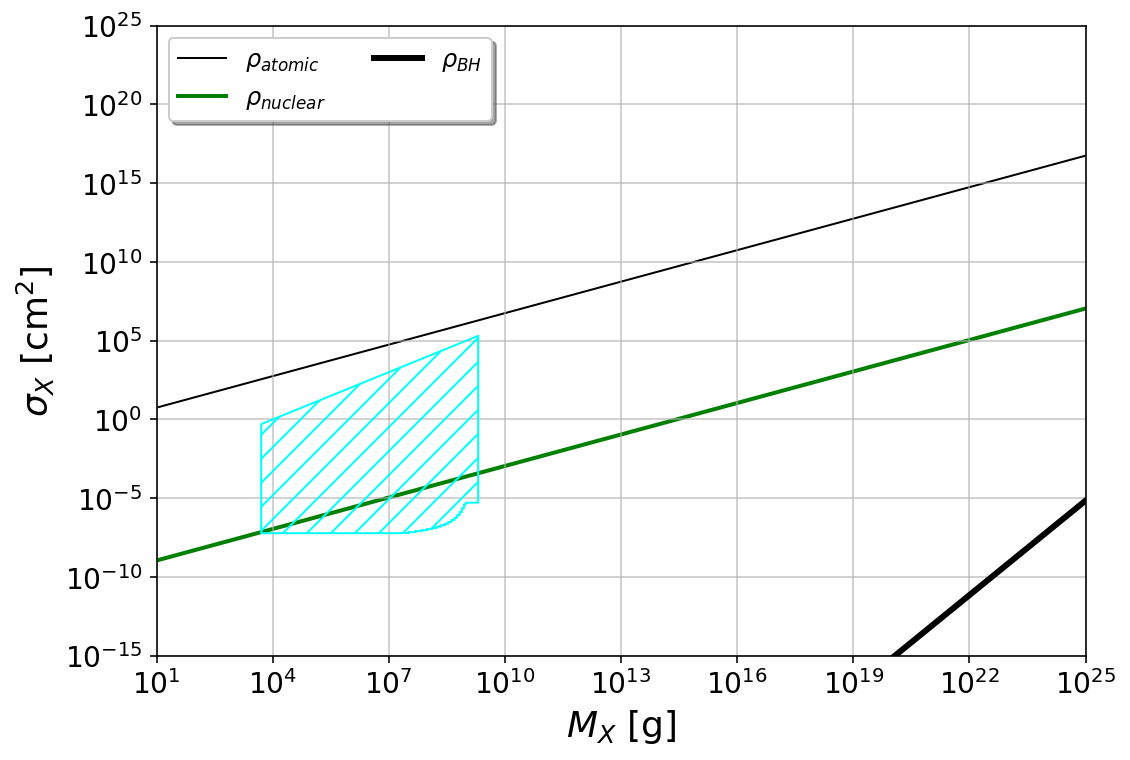

In [12]:
m_arr = np.logspace(1, 25)

with plot.constraints_plot(m_arr, sigmin=1e-15):

    plt.fill_between(
        jupitermasslightning,
        Shold,
        uppersigmalightningjupiter,
        where=None,
        facecolor="none",
        edgecolor="cyan",
        hatch="//",
        alpha=1.0,
        zorder=4,
    )

plt.show();

### Plotting Phase Space Constraints

Plotting both Earth and Jupiter lightning constraints on macro mass and cross-section.

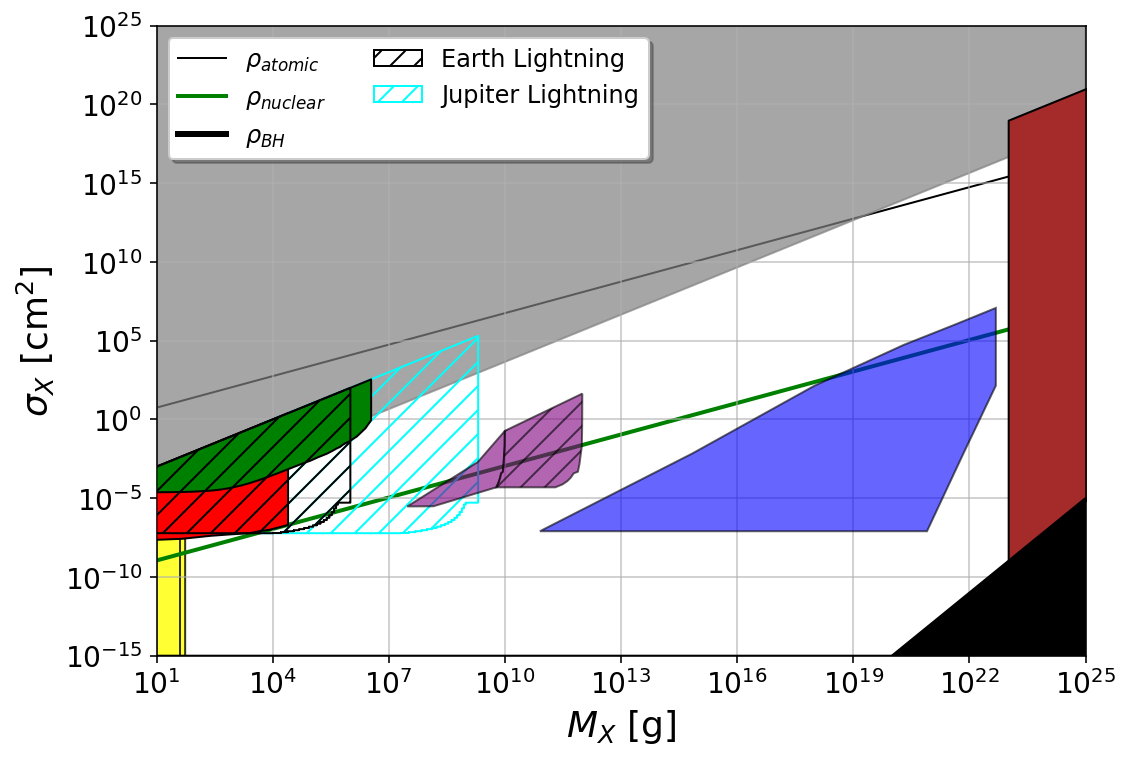

In [13]:
with plot.constraints_plot(
    m_arr=np.logspace(1, 25),
    sigmin=1e-15,
    sigmax=1e25,
    all_constrs=True,  # previous constraints
    savefig='figures/lightningconstraints.pdf',
) as (fig, ax, m_arr, ymin, ymax):

    plt.fill_between(
        Mhold, Shold, upperlightning,
        where=None, 
        facecolor='none',
        edgecolor='black',
        hatch="//",
        alpha=1.0,
        zorder=8,
        label="Earth Lightning"
    )
    plt.fill_between(
        jupitermasslightning,
        Shold,
        uppersigmalightningjupiter,
        where=None,
        facecolor="none",
        edgecolor="cyan",
        hatch="//",
        alpha=1.0,
        zorder=4,
        label="Jupiter Lightning"
    )

# /with

plt.show();


<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>